In [25]:
import csv
import datetime
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import namedtuple
from openpyxl import load_workbook
from scipy.optimize import curve_fit

In [26]:
pipe_material_xlsx_path = r'/Users/macbookairfromboeing/Downloads/Penn/Courses/2025 Fall/ENVS 5726/Week 09 - Updated Version/Week09AssignmentData/Pipe_Material_Training_Data.xlsx'

workbook = load_workbook(pipe_material_xlsx_path)
sheet = workbook['Survival Probabilities']

pipe_material_table = []
headers = [cell.value for cell in next(sheet.iter_rows())]

for row in sheet.iter_rows(min_row=2):
    pipe_material_table.append([cell.value for cell in row])

In [27]:
def cumulative_density_function(age, c, b, a):
    return 1-c*np.exp(-(age/b)**a)
    
def plot_cdf_curve_fit(table:list, material_type:str, line_color:str):

    xdata = []
    ydata = []
    
    for row in table:
        if row[headers.index('Material Type')] == material_type:
            xdata.append(float(row[headers.index('Life Expectancy (y)')]))
            ydata.append(float(row[headers.index('Surv. Prob. (%)')]))
    
    coefficients, bounds = curve_fit(cumulative_density_function, xdata, ydata)
    c, b, a = coefficients
    print(f'Curve fitted CDF for {material_type}: Survival Probability = {c}* e^ (-(age/{b})^{a})')

    max_life_exp = max([row[headers.index('Life Expectancy (y)')] for row in table])
    x_curve = range(max_life_exp)
    y_curve = [cumulative_density_function(x, *coefficients) for x in x_curve]

    plt.plot(x_curve, y_curve, color=line_color, label=material_type)

    return coefficients

Curve fitted CDF for Cast Iron: Survival Probability = -101.18515204972083* e^ (-(age/90.22965174962111)^1.7385295488806634)
Curve fitted CDF for Ductile Iron: Survival Probability = -103.04474918465641* e^ (-(age/65.3934144943203)^1.7135618198212321)
Curve fitted CDF for Galvanized Iron: Survival Probability = -126.39516495449556* e^ (-(age/25.926419901386076)^1.4793941371960506)
Curve fitted CDF for Copper: Survival Probability = -107.47743252086387* e^ (-(age/43.83294562977286)^1.6910765551174167)
{'Cast Iron': array([-101.18515205,   90.22965175,    1.73852955]), 'Ductile Iron': array([-103.04474918,   65.39341449,    1.71356182]), 'Galvanized Iron': array([-126.39516495,   25.9264199 ,    1.47939414]), 'Copper': array([-107.47743252,   43.83294563,    1.69107656])}


/var/folders/ks/g07lt0kd44dgzjhdy2x3cldm0000gn/T/ipykernel_23748/1042962654.py:2: RuntimeWarning: invalid value encountered in power
  return 1-c*np.exp(-(age/b)**a)
/var/folders/ks/g07lt0kd44dgzjhdy2x3cldm0000gn/T/ipykernel_23748/1042962654.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  coefficients, bounds = curve_fit(cumulative_density_function, xdata, ydata)


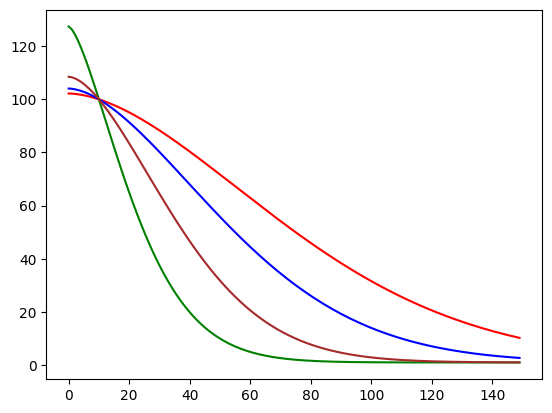

In [28]:
material_coefficients = {}
material_coefficients['Cast Iron'] = plot_cdf_curve_fit(table=pipe_material_table, material_type='Cast Iron', line_color='red')
material_coefficients['Ductile Iron'] = plot_cdf_curve_fit(table=pipe_material_table, material_type='Ductile Iron', line_color='blue')
material_coefficients['Galvanized Iron'] = plot_cdf_curve_fit(table=pipe_material_table, material_type='Galvanized Iron', line_color='green') 
material_coefficients['Copper'] = plot_cdf_curve_fit(table=pipe_material_table, material_type='Copper', line_color='brown')
print(material_coefficients)

In [29]:
csv_path = Path(r'/Users/macbookairfromboeing/Downloads/Penn/Courses/2025 Fall/ENVS 5726/Week 09 - Updated Version/Week09AssignmentData/Water_Mains.csv')


with open(csv_path, 'r', encoding='utf-8-sig') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader)

    WaterMain = namedtuple(typename='WaterMain', field_names=headers)

    water_main_table = []

    for row in reader:
        water_main = WaterMain(*row)
        water_main_table.append(water_main)

In [30]:
NewWaterMain = namedtuple(
    typename='NewWaterMain',
    field_names=list(WaterMain._fields) + ['Age'] + ['Survival_Probability']
)

In [31]:
water_main_table_with_age_probability = []
for row in water_main_table:

    install_date = row.InstallDate
    cleaned_install_date = datetime.datetime.strptime(install_date, '%m/%d/%Y %H:%M')

    age = 2025-cleaned_install_date.year

    # Calculating survival_probability
    material = row.Material
    coefficients = material_coefficients[material]
    c, b, a = coefficients
    survival_probability = float(cumulative_density_function(age, c, b, a))
    if survival_probability > 100:
        survival_probability = 100
    else:
        survival_probability = survival_probability
    
    updated_installdate_row = row._replace(InstallDate = cleaned_install_date)
    new_row = NewWaterMain(
        *updated_installdate_row,
        Age = age,
        Survival_Probability = survival_probability
    )

    water_main_table_with_age_probability.append(new_row)
    
for row in water_main_table_with_age_probability[:5]:
    print(row)

NewWaterMain(MainType='Distribution', Diameter='14', InstallDate=datetime.datetime(2018, 8, 9, 16, 40), Material='Galvanized Iron', Age=7, Survival_Probability=100)
NewWaterMain(MainType='Distribution', Diameter='6', InstallDate=datetime.datetime(2015, 5, 29, 15, 45), Material='Copper', Age=10, Survival_Probability=100.0)
NewWaterMain(MainType='Distribution', Diameter='8', InstallDate=datetime.datetime(2021, 7, 30, 16, 29), Material='Cast Iron', Age=4, Survival_Probability=100)
NewWaterMain(MainType='Distribution', Diameter='8', InstallDate=datetime.datetime(2016, 4, 11, 3, 38), Material='Copper', Age=9, Survival_Probability=100)
NewWaterMain(MainType='Distribution', Diameter='12', InstallDate=datetime.datetime(1996, 5, 12, 15, 32), Material='Cast Iron', Age=29, Survival_Probability=89.05486478160739)
